In [ ]:
!pip install opendatasets

In [38]:
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
from keras.callbacks import ModelCheckpoint

from keras.models import load_model

import opendatasets as od


import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Flatten, Dense, Dropout, Activation, ZeroPadding2D, MaxPooling2D, InputLayer
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

## Importing data

In [40]:
od.download("https://www.kaggle.com/datasets/deadskull7/fer2013", force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading fer2013.zip to ./fer2013


100%|██████████| 96.6M/96.6M [00:16<00:00, 6.04MB/s]


In [ ]:
data = pd.read_csv('fer2013.cvs')

In [34]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [35]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## Split into train and test sets

In [36]:
def convert_to_float(x):
    return [float(value) for value in x]

data['pixels'] = np.array(data['pixels'].str.split())

data['pixels'] = data['pixels'].apply(convert_to_float)

In [37]:
X_train = data[data['Usage'] == 'Training']
X_val = data[data['Usage'] == 'PublicTest']
X_test = data[data['Usage'] == 'PrivateTest']

# converts Series to list
y_train = X_train['emotion'].tolist()
# converts Series to nd.array
X_train = np.array(X_train['pixels'].tolist())

y_val = X_val['emotion'].tolist()
X_val = np.array(X_val['pixels'].tolist())

y_test = X_test['emotion'].tolist()
X_test = np.array(X_test['pixels'].tolist())

KeyboardInterrupt: 

In [ ]:
X_train.shape

(28709, 2304)

In [ ]:
# reshape the images to be in 48 x 48 x 1 pixels format
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [ ]:
X_train.shape

(28709, 48, 48, 1)

In [ ]:
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val, num_classes= 7)
y_test = to_categorical(y_test, num_classes= 7)

In [ ]:
y_val

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
y_val.shape

(3589, 7)

## Visualizing images

In [ ]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

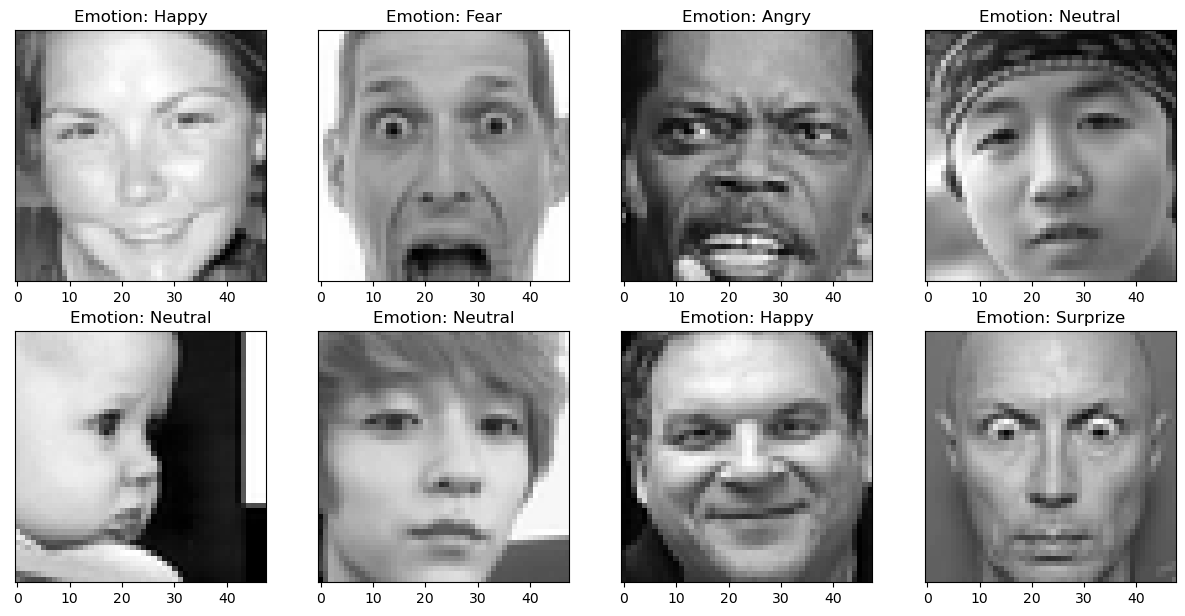

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(0, 8):
    img = np.array([j for j in  data['pixels'][i+8]] , dtype='float').reshape(48,48)
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(img, cmap = 'gray')
    plt.title("Emotion: " + emotions[data['emotion'][i+8]])
    plt.xticks()
    plt.yticks([])
    plt.axis = ('off')

## Network architecture - VGG16

In [ ]:
model = Sequential([
    
    # ZeroPadding2D((1, 1), input_shape = (48, 48, 1)),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48, 1)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2,2)),

    # ZeroPadding2D((1, 1)),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2,2)),

    # ZeroPadding2D((1, 1)),
    Conv2D(256, (3,3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2,2)),
    
    Conv2D(512, (3,3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    Conv2D(512, (3,3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2,2)),

    Flatten(),
    Dense(4096, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(7, activation = 'softmax')
])

model.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

2022-11-22 23:16:28.845579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 23:16:28.851506: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Data Augmentation

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True) # horizontal flip

## Model training

In [ ]:
filepath = 'emotion_detector.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [ ]:
history = model.fit(datagen.flow(X_train,y_train,
                                       batch_size=32, 
                                       seed=27,
                                       shuffle=False),
                    epochs=30,
                    steps_per_epoch=X_train.shape[0] // 32,
                    validation_data=(X_val,y_val),
                    callbacks = callbacks,
                    verbose = True)

# Plots of training history

In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('model_training_history')
plt.show()

In [ ]:
PATH = "emotion_detector.hdf5"

model = load_model(PATH)